Stability tests for continuous-time stochastic volatility models based off the Nymblom stability test.

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from jax import lax
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pfjax as pf
import pfjax.sde as sde

from functools import partial

from pfjax import particle_resamplers as resampler

import time
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

# needed for local imports in Jupyter:
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)

In [4]:
from particle_gibbs import *
from sv_model import * 
from utils import * 

In [5]:
key = random.PRNGKey(100)
# key, subkey = jax.random.split(key)

_dt = 1
_n_res = 5
n_obs = 500

# parameters: 
_theta = 0.2
kappa = -0.05
sigma_z = 0.12
mu = 0.008

# theta = jnp.array([_theta, kappa, sigma_z, mu])
theta = jnp.array([_theta, kappa, mu])
x_init = jnp.block([[jnp.zeros((_n_res-1, 2))],
                    [jnp.array([2.0, 45.0])]])

volmodel = StochVol(_dt, _n_res, sigma_z=sigma_z)
y_meas1, x_state1 = pf.simulate(volmodel, key, n_obs, x_init, theta)

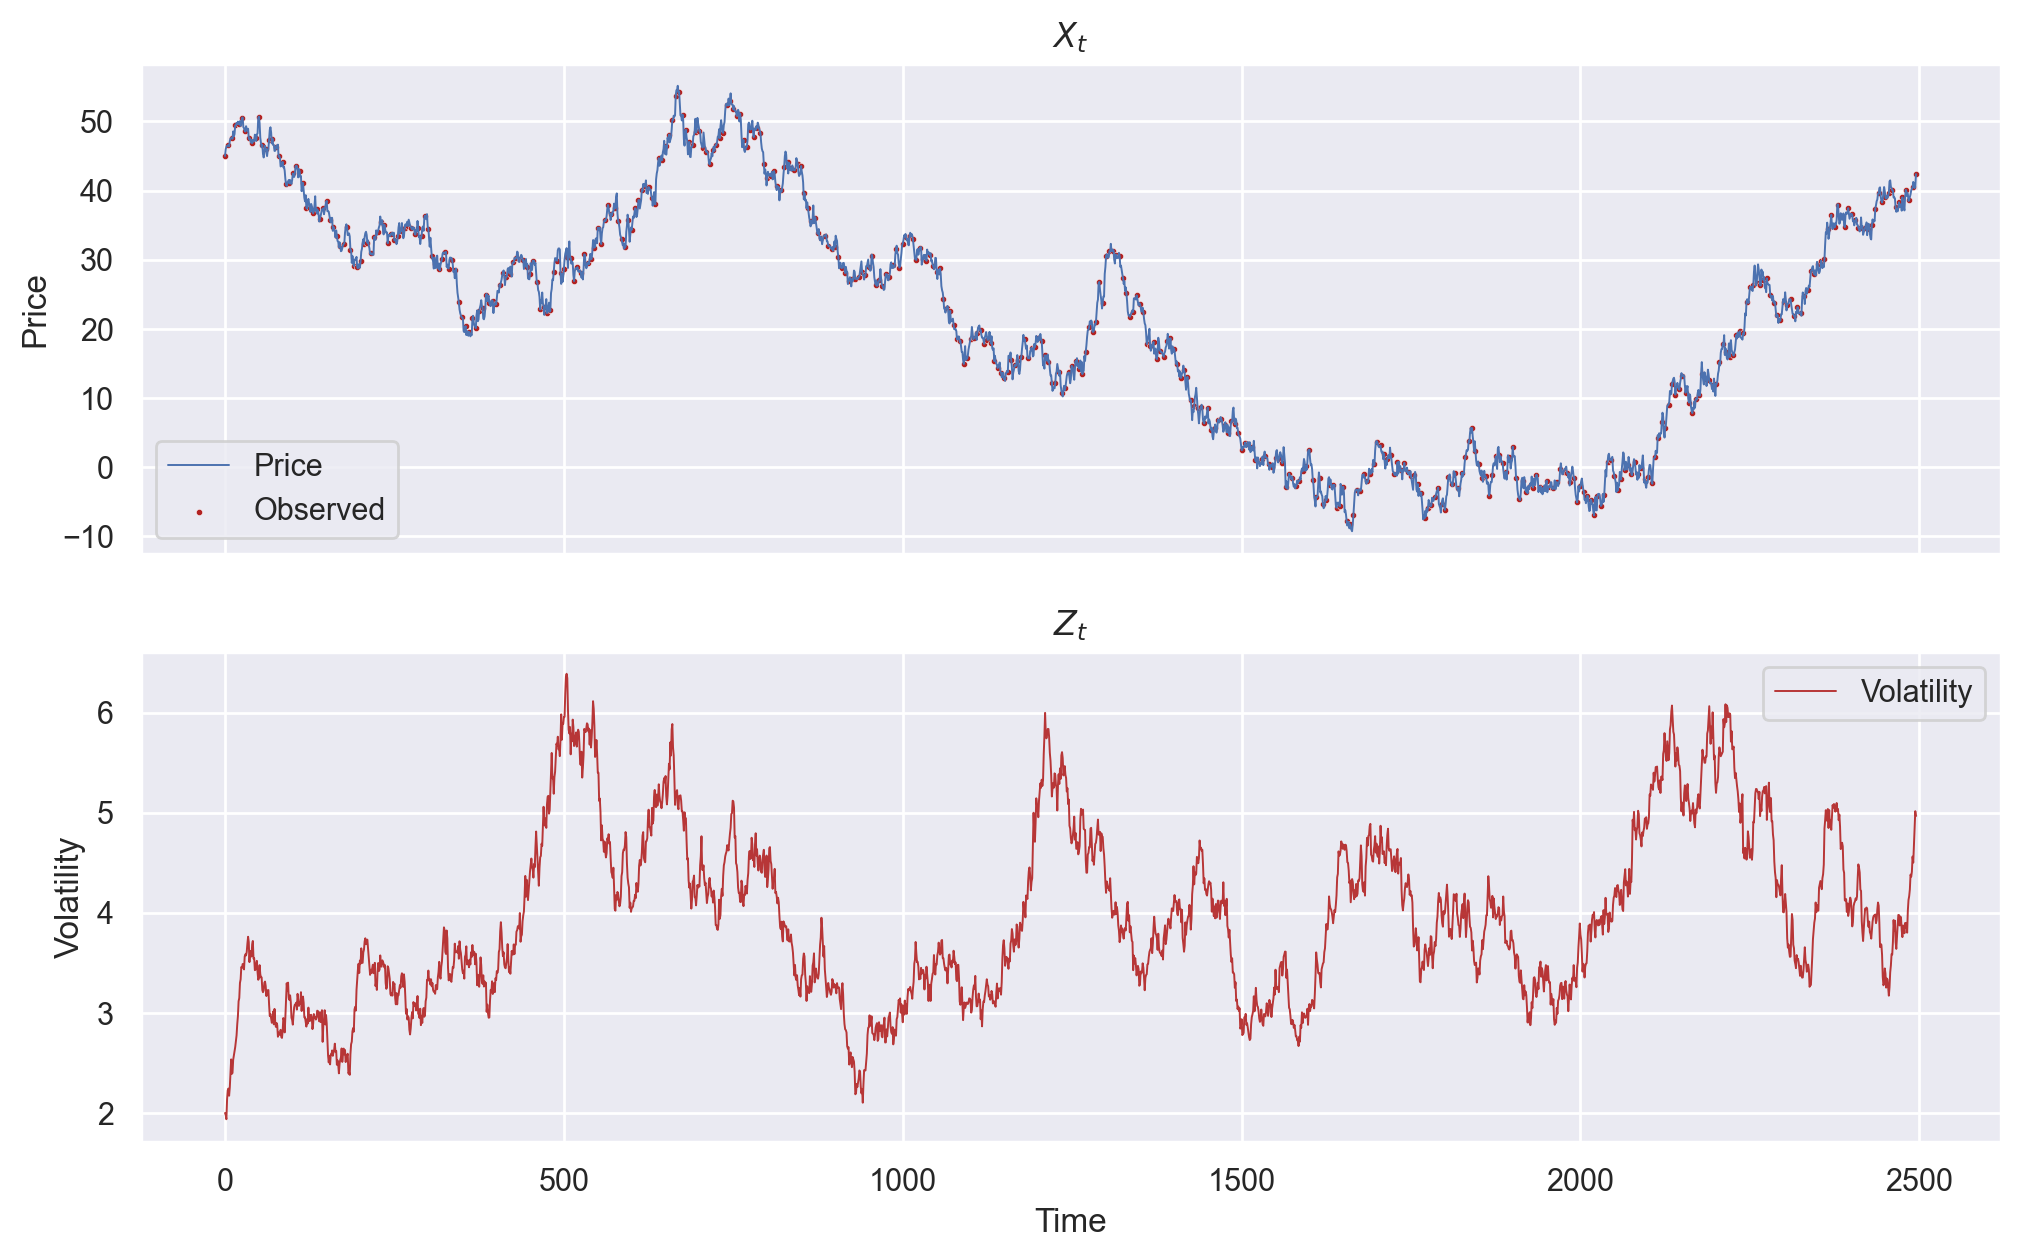

In [6]:
point_plot = pd.DataFrame(jnp.array([
    jnp.arange(y_meas1.shape[0]) * _n_res,
    y_meas1
]).T, columns = ["Time", "Log Asset Price"])

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 7), sharex = True)

sns.lineplot(data= x_state1[..., 1].reshape(_n_res*n_obs, 1)[(_n_res-1):].squeeze(),
             ax = ax[0], linewidth=0.7,
             label = "Price").set(title ="$X_t$", ylabel="Price")
sns.scatterplot(x = "Time", y = "Log Asset Price", 
                data = point_plot,
                color = "firebrick",
                ax = ax[0],
                s=5,
                label="Observed").set(title ="$X_t$")

sns.lineplot(data= x_state1[..., 0].reshape(_n_res*n_obs,1)[(_n_res-1):].squeeze(),
             ax = ax[1], alpha = 0.9, linewidth=0.7, color = "firebrick",
             label = "Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility");

In [7]:
def sv_logprior (theta):
    """
    Prior for theta 
    
    \theta ~ TruncatedNormal(0, 5)
    \kappa ~ TruncatedNormal(-5, 0)
    \mu ~ flat prior
    
    TODO: Try gamma prior for these parameters. We can put a gamma prior on -kappa
    """
    kappa_scale = 5
    theta_scale = 5
    kappa_prior = jax.scipy.stats.truncnorm.logpdf(theta[1], -25/kappa_scale, 0, scale=kappa_scale)
    theta_prior = jax.scipy.stats.truncnorm.logpdf(theta[0], 0, 25/theta_scale, scale=theta_scale)
    return kappa_prior + theta_prior

# Stability Tests

In this stability test, we split the observed data into 2 new datasets. Each dataset is used to estimate the parameters of the model. The posteriors of each fit are then overlayed on each other, if there is significant overlap we can conclude that the model is appropriate.

In [11]:
mid = int(n_obs/2)

h1 = y_meas1[:mid]
h2 = y_meas1[mid:]

n_particles = 100
n_iter = 2500
theta_init = jnp.array([0.1, -0.2, 0.2])

In [12]:
h1_params = parameter_estimates(
    key,
    model=volmodel,
    y_meas=h1,
    theta_init=theta_init,
    logprior=sv_logprior,
    n_particles=n_particles,
    n_iter = n_iter
)
plot_posteriors(h1_params, theta_true=theta, theta_init=theta_init)

Acceptance rate:  [0.4664 0.4372 0.4428]


Acceptance rate:  [0.4388 0.4228 0.456 ]


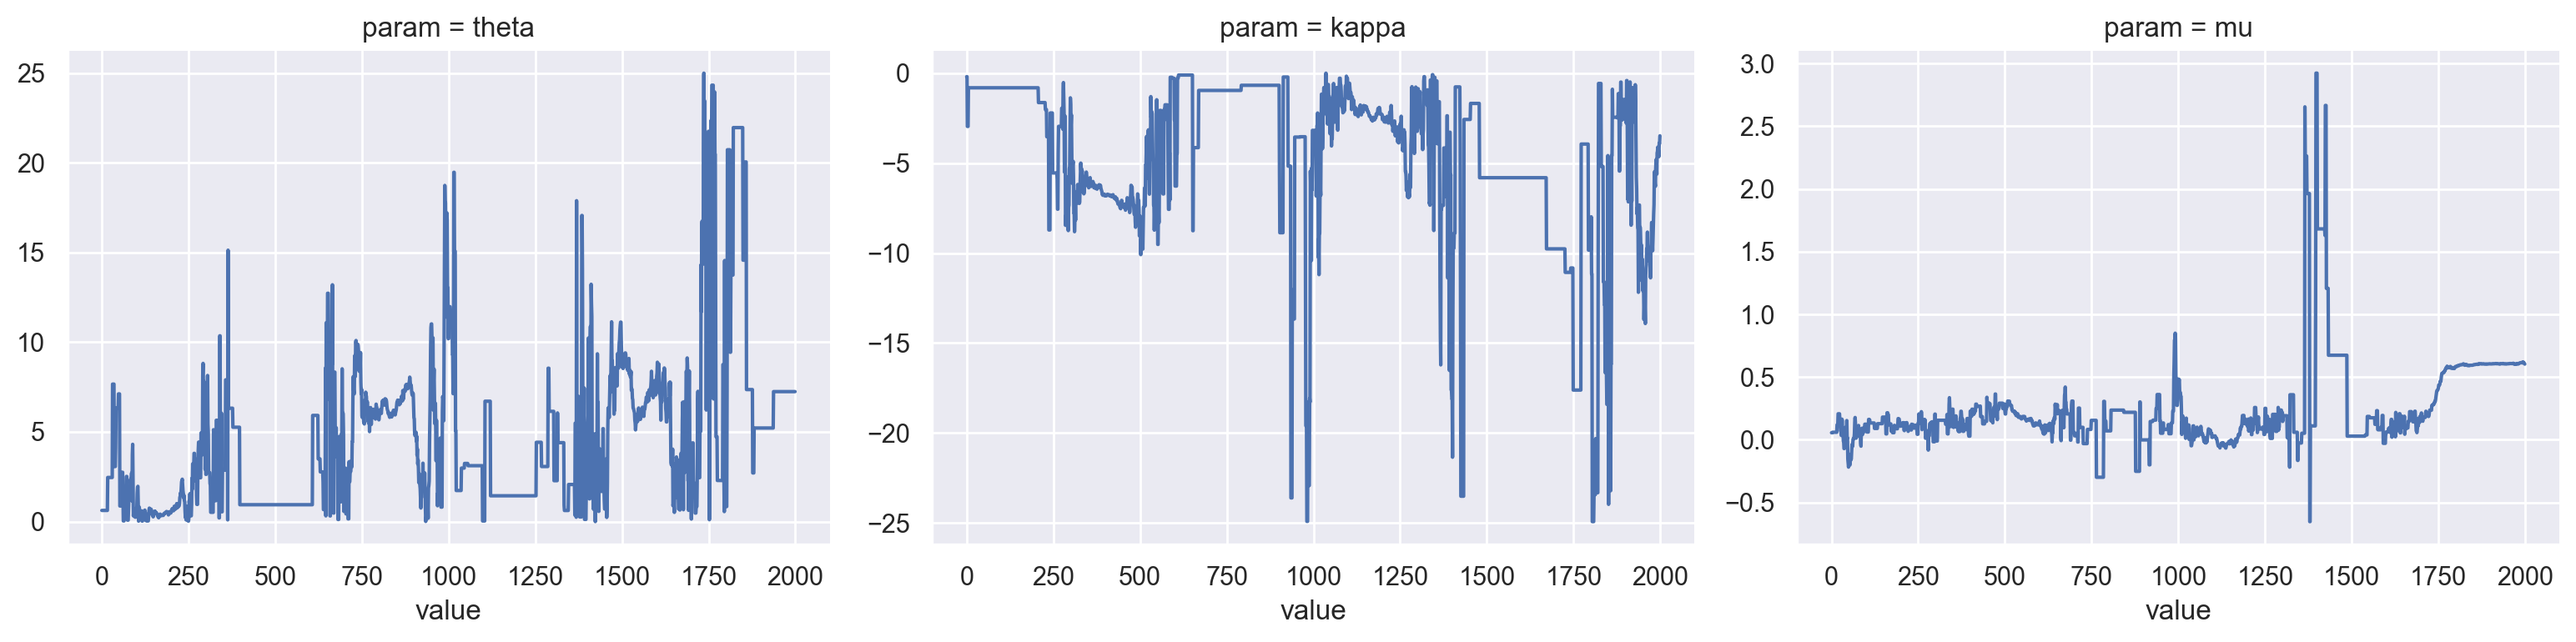

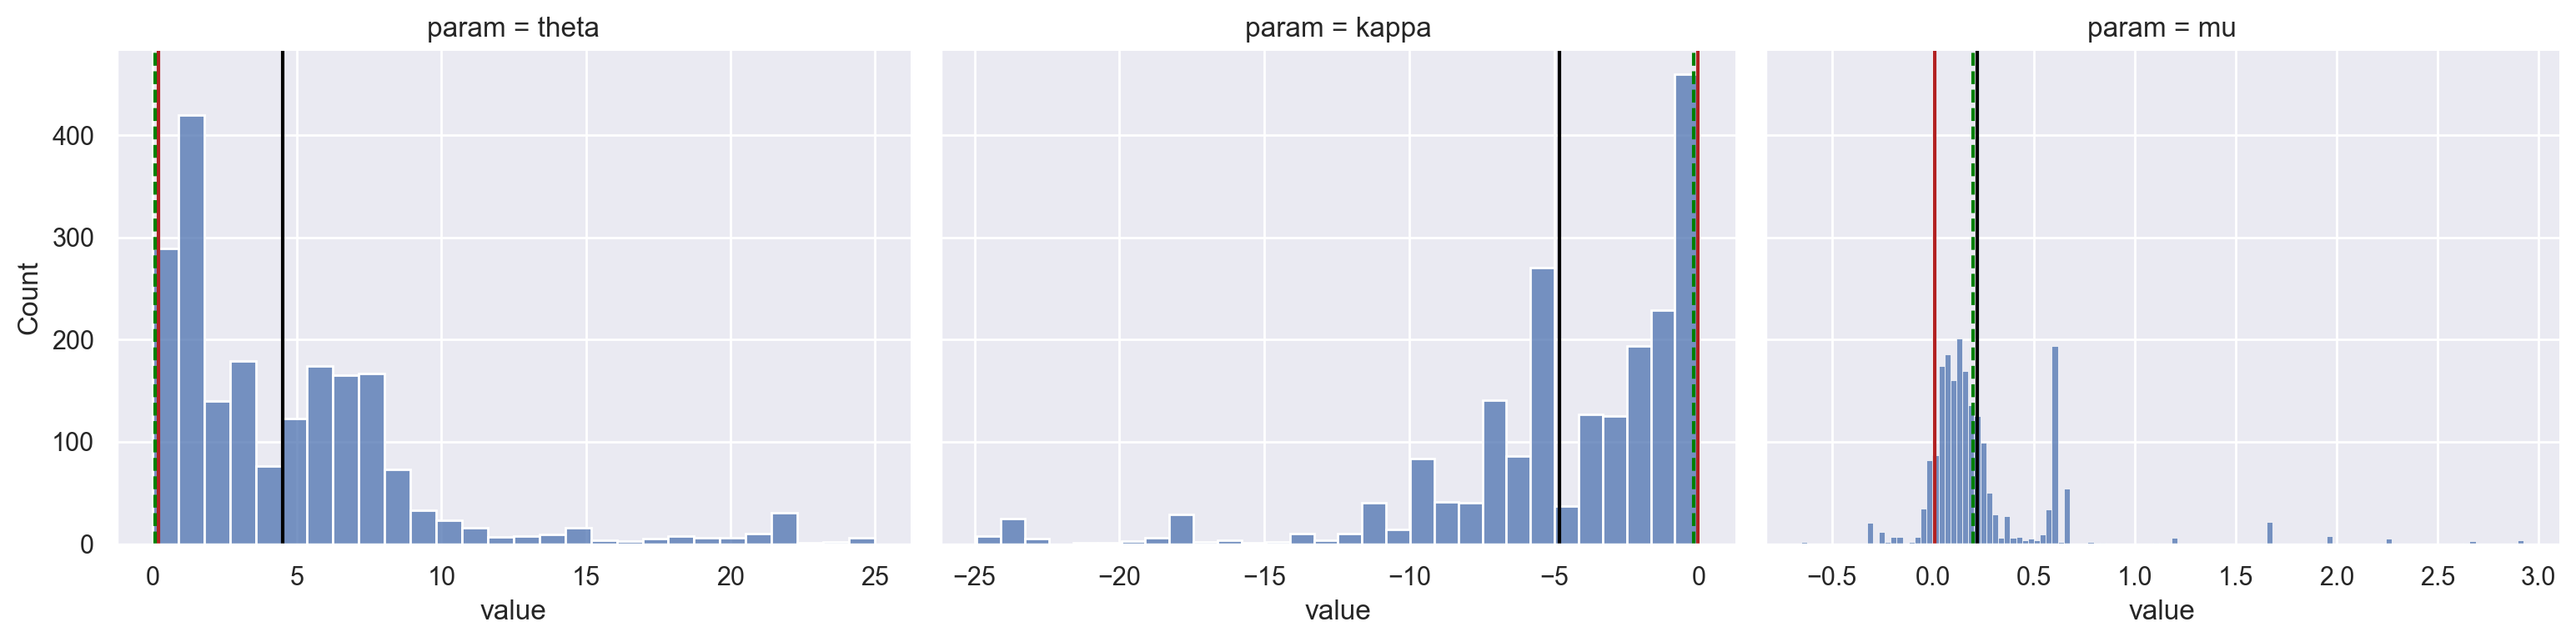

In [13]:
h2_params = parameter_estimates(
    key,
    model=volmodel,
    y_meas=h2,
    theta_init=theta_init,
    logprior=sv_logprior,
    n_particles=n_particles,
    n_iter = n_iter
)
plot_posteriors(h2_params, theta_true=theta, theta_init=theta_init)

In [14]:
posterior1 = pd.DataFrame(
    h1_params["theta"], 
    columns = ["theta", "kappa", "mu"])
posterior1["selection"] = "first"

posterior2 = pd.DataFrame(
    h2_params["theta"], 
    columns = ["theta", "kappa", "mu"])
posterior2["selection"] = "second"

plot_posteriors = pd.melt(pd.concat([posterior1, posterior2]), id_vars=["selection"], var_name = "param")

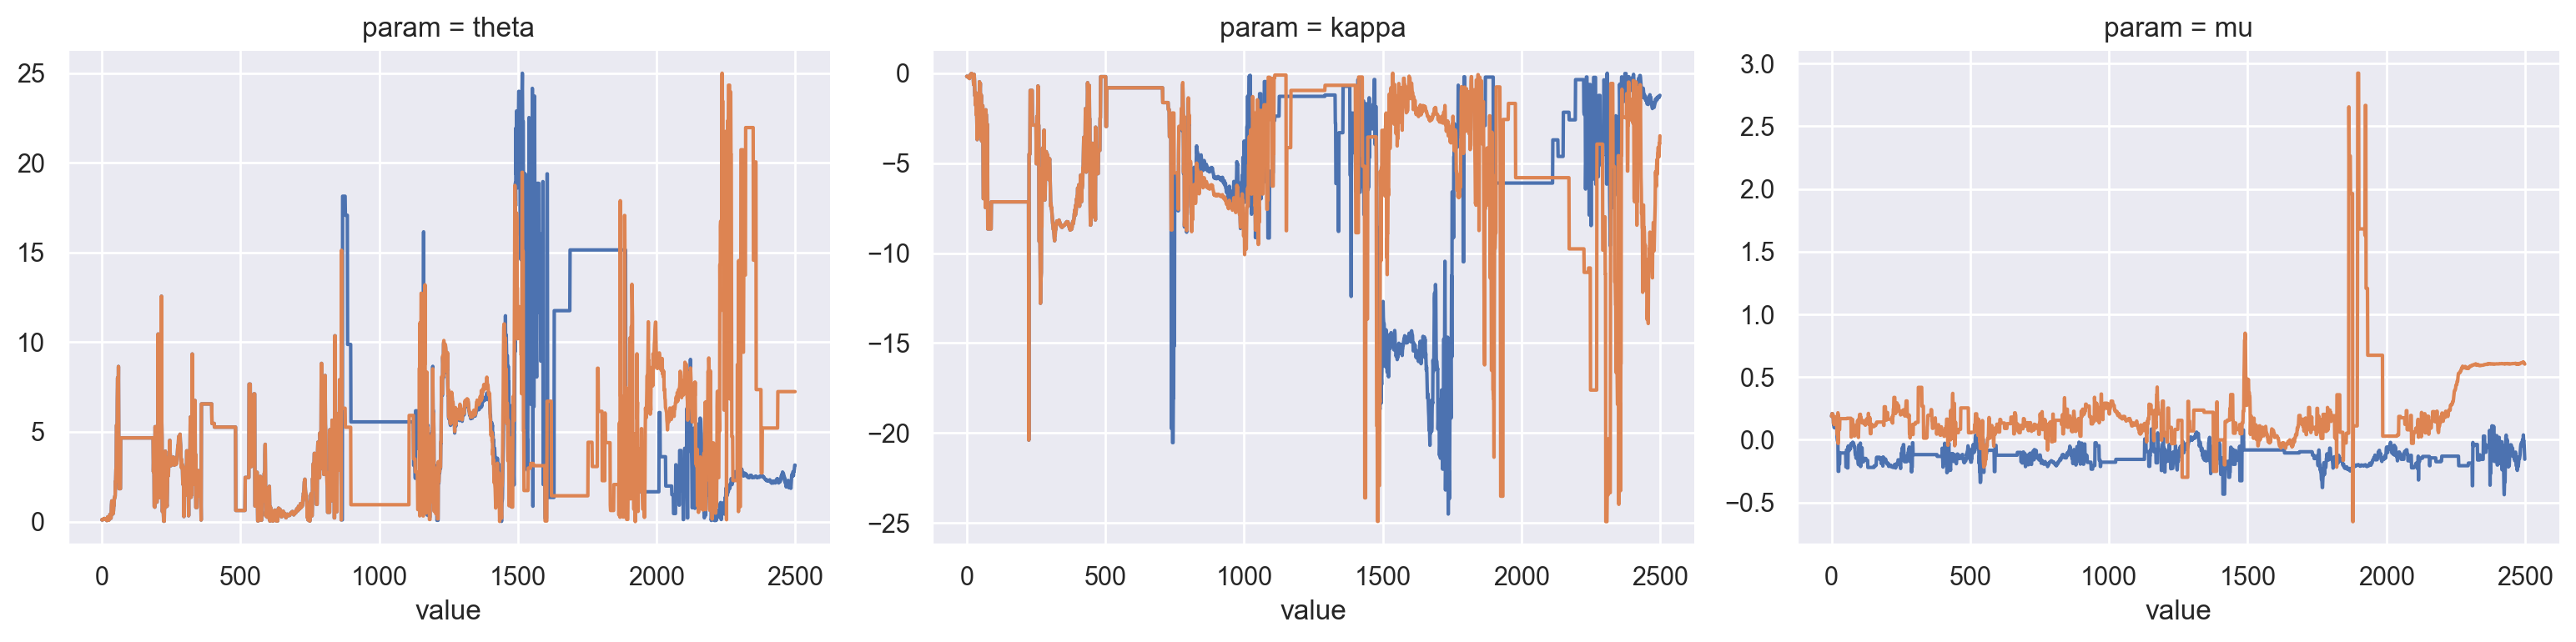

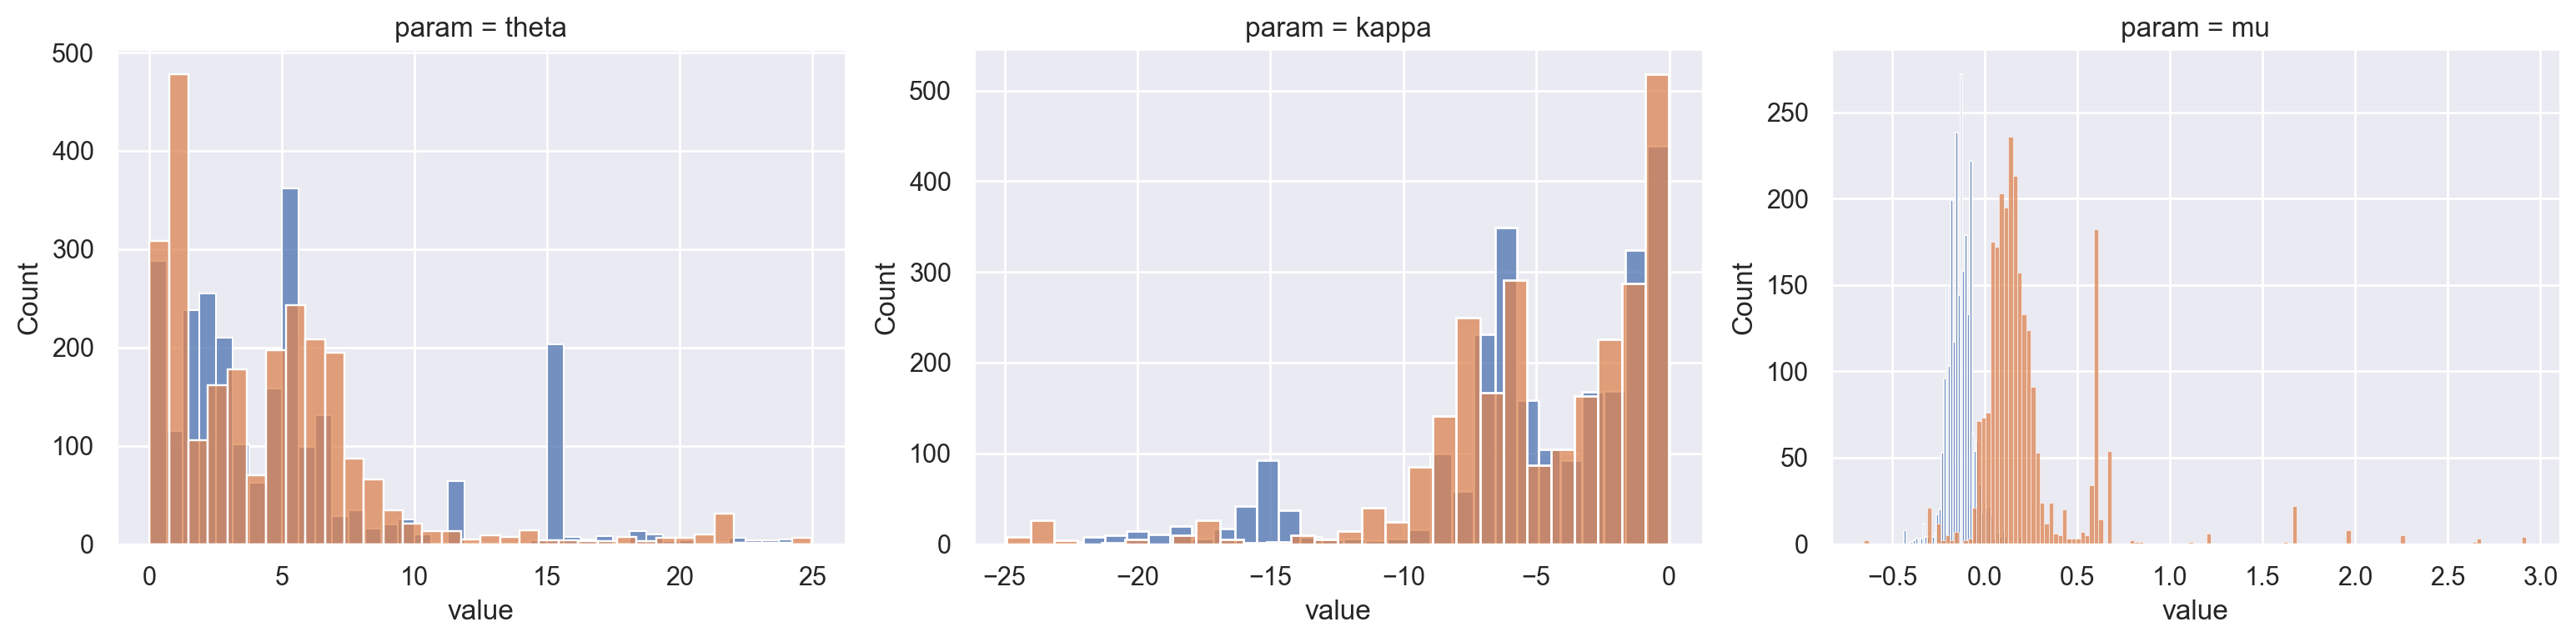

In [15]:
g = sns.FacetGrid(plot_posteriors,
                  sharex=True, sharey=False,
                  col="param", hue="selection",
                  height=4, aspect=1.3)
g.map(plt.plot, "value");

g = sns.FacetGrid(plot_posteriors,
                  sharex=False, sharey=False,
                  col="param", hue="selection",
                  height=4, aspect=1.3)
g.map(sns.histplot, "value");